This notebook takes 2 signals/images. The intrinsic signal is given in the "intrinsic_func".

In [309]:
%reset -f
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np

In [310]:
def kernel(a, b,l):
    sqd=np.subtract.outer(a,b)**2
    return np.exp(-0.5*sqd/(l*l))

def get_GP_mean(tp,P,t,l):
    K=kernel(tp,tp,l);       #NPxNP
    Ks=kernel(tp,t,l);       #NPxN
    L=np.linalg.cholesky(K)# + 1e-15*np.eye(NP)); #NPxNP
    Lk=np.linalg.solve(L,Ks);      #NPxN
    z=np.linalg.solve(L,P);        #NP
    m=np.dot(Lk.T,z)   # ((Lk)')*z;// N
    return m;

In [311]:
%matplotlib inline
np.random.seed(15)
tk=10.0
def intrinsic_func(t,mu,dt):
    t1=t+dt;
    t1[t1<0]=0
    return mu*(t1)**2*np.exp(-(t1)/tk)

t_max=100.0; t_min=0.0; t_range=t_max-t_min; Ndata=200;
t=t_min+np.random.rand(Ndata)*t_range;t=np.sort(t);
#a slight shift is given because fitting may have problem with a very small \sigma 
print(np.amin(t), np.amax(t))

0.16447577600704477 99.8543402727172


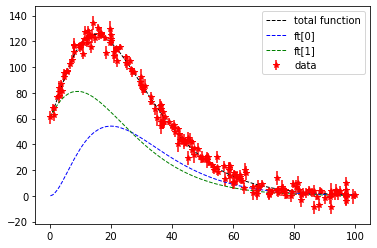

chi^2: if actual model: chi^2= 201.93980717339545


In [312]:
#mu and dt for the images
mu_l=[1.0,1.5]
dt_l=[0.0,11.0]
#for simplicity just consider the 1st NI images for now
NI=2; #just take two signal/image 
ft=np.zeros((NI,Ndata))

for i in np.arange(NI): 
    ft[i]=intrinsic_func(t,mu_l[i],dt_l[i])
    
ft_total=np.sum(ft,axis=0)
#sigft=0.05*ft_total+1.0  #10*(0.2+np.random.rand(len(t)))
sigft=5*(0.2+np.random.rand(len(t)))
np.random.seed(37)

y=np.random.normal(ft_total, sigft)#this is my data

plt.errorbar(t,y,yerr=sigft,fmt='r*',label=r"data") #data
plt.plot(t,ft_total,c='k',lw=1.0,ls="--", label=r"total function")
clr=["b","g","c","orange"]
for i in range(NI):
    plt.plot(t,ft[i],c=clr[i],lw=1.0,ls="--", label=r"ft[%d]"%(i))

plt.legend(loc=0)
plt.show()
chi2_am=np.sum(((y-ft_total)/sigft)**2)
print("chi^2: if actual model: chi^2=",chi2_am)

Using GP mean function instead of interpolation

We choose NP number of free parameters P. They represent the first image. The 2nd image is scaled by mu and has time delay dt (positive dt means the image shifted towards left, hence arrives earlier). To construct the first signal from the values of the parameters P we use GP mean function.

In [313]:

model = """
functions{
    matrix kernel1(vector x0, vector x1, real l, int d){
        matrix [d,d] a;
        for (i in 1:d)
        {
            for (j in 1:i)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
                a[j][i]=a[i][j];
            }
            
        }
        return a;
    }
    
    matrix kernel2(vector x0, vector x1, real l, int d1, int d2){
        matrix [d1,d2] a;
        for (i in 1:d1)
        {
            for (j in 1:d2)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
            }
            
        }
        return a;
    }
    //================== calculating GP mean function =============================
    vector GP_mean(vector tp, vector t, vector P, real l, int NP, int N)
    {
        matrix[NP,NP] K;
        matrix[NP,NP] L;
        matrix[NP,N] Ks;
        matrix[NP,N] Lk;
        vector[NP] z;
        vector[N] m;
    
        K=kernel1(tp,tp,l, NP);       //NPxNP
        Ks=kernel2(tp,t,l, NP,N);       //NPxN
        L=cholesky_decompose(K); //NPxNP
        Lk=L\Ks;      //NPxN
        z=L\P;        //NP
        m=((Lk)')*z;// N
        return m;
    }
    //==============================================================================
}

data {
    int<lower=0> N;
    int<lower=0> ni;
    int<lower=5> NP;
    vector[N] t;
    vector[N] y;
    vector[N] yerror;
    vector[NP] tp;
    real td;
    real dt_max;
}
parameters {
    vector <lower=0.0, upper=150.0> [NP] P;
    real<lower=5.0, upper=20.0> l;
    real<lower=0.25, upper=4.0> mu;//actually measuring amplitudes relative 
    //simplex[ni] dt_r;
    real <lower=0, upper=dt_max> dt;
    
    
    
    
}
/*
//transformed parameters {
//    positive_ordered[ni-1] dt = dt_max*cumulative_sum(dt_r[:ni-1]);
//}*/

model {
    vector[N] dum;

    //dum needs GP
    dum=GP_mean(tp, t, P, l, NP, N); //first image
    dum=dum+mu*GP_mean(tp, t+dt, P, l, NP, N); //adding the 2nd image
    
    
    target+=normal_lpdf(y|dum,yerror);

}
"""
NI=2
NP=9;
dt_min=0.0; dt_max=20.0
#t_range=np.amax(t)-np.amin(t)
tp=np.linspace(np.amin(t), np.amax(t)+dt_max, NP)
print("tp=",tp)
td=(t_max-t_min+dt_max-dt_min)/(NP-1); print("td=",td);
data = {'N': len(t),'ni':NI,'NP':NP, 't': t, 'y': y, 'yerror':sigft,'tp':tp,'td':td, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit4 = sm.sampling(data=data, iter=3000, chains=8, warmup=400, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit4)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_08b3e68d2d19a7c101786d460582b0d8 NOW.


tp= [  0.16447578  15.12570884  30.0869419   45.04817496  60.00940802
  74.97064109  89.93187415 104.89310721 119.85434027]
td= 15.0


Inference for Stan model: anon_model_08b3e68d2d19a7c101786d460582b0d8.
6 chains, each with iter=2000; warmup=400; thin=3; 
post-warmup draws per chain=534, total post-warmup draws=3204.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P[1]  12.04    0.23   8.58    0.4   4.85  11.06  17.39  31.65   1444    1.0
P[2]  75.78    0.86  13.85  48.59  65.18  77.54  86.23  99.82    259   1.03
P[3]  59.39    0.59   8.73  41.33  52.49  61.34  66.04  72.85    218   1.03
P[4]  29.61    0.31   4.52  20.72  25.91  30.47  33.32  36.33    208   1.03
P[5]  11.33    0.09   1.39   8.32  10.36  11.65  12.37  13.48    243   1.03
P[6]   3.26    0.05   0.81   1.88   2.62   3.23   3.83   4.89    282   1.02
P[7]   1.06    0.01   0.53   0.09   0.68   1.04   1.41   2.12   1275    1.0
P[8]   1.12    0.02   0.89   0.06   0.48    0.9   1.53   3.23   2053    1.0
P[9]   6.36    0.21   6.61   0.14   1.89   4.46   8.44   24.7    998   1.01
l     15.92    0.37   4.77   7.48   9.74  18.67  19.5

In this notebook

13 [12.04193728 75.77982317 59.39481163 29.61311665 11.33486896  3.25933297
  1.05556355  1.11569703  6.36164344]
P's are calculated at t=  [  0.16447578  15.12570884  30.0869419   45.04817496  60.00940802
  74.97064109  89.93187415 104.89310721 119.85434027]


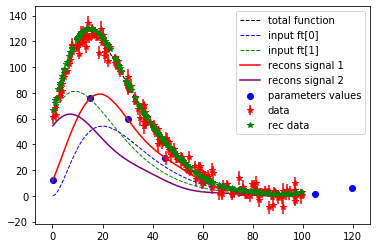

Chi^2 actual= 201.93980717339548 Chi^2 pystan rec= 417.43084252786036


In [320]:
NP=9
tp=np.linspace(np.amin(t), np.amax(t)+dt_max, NP)
pp1=fit4.get_posterior_mean()
pos_mean=np.mean(pp1,axis=1)
P_mean=pos_mean[np.arange(0,NP)]; 
print(len(pos_mean),P_mean)
lm=pos_mean[-4]; mum=pos_mean[-3]; dtm=pos_mean[-2];
print("P's are calculated at t= ",tp)


Ps1=get_GP_mean(tp,P_mean,t,lm)
Ps2=mum*get_GP_mean(tp,P_mean,t+dtm,lm)

rconst_signal=Ps1+Ps2#+Ps3+Ps4;
Ps=Ps1+Ps2

plt.errorbar(t,y,yerr=sigft,fmt='r*',label=r"data") #data
plt.plot(t,ft_total,c='k',lw=1.0,ls="--", label=r"total function")
clr=["b","g","c","orange"]
for i in range(NI):
    plt.plot(t,ft[i],c=clr[i],lw=1.0,ls="--", label=r"input ft[%d]"%(i))

plt.plot(t,Ps1,c="r",label="recons signal 1" )  
plt.plot(t,Ps2,c="purple",label="recons signal 2") 
plt.errorbar(t,Ps,fmt='g*',label=r"rec data") #data    
plt.scatter(tp,P_mean,c='b',label="parameters values")
plt.legend(loc=0)
plt.show()
chisq=np.sum((Ps-y)**2/sigft**2)
chisq_o=np.sum((ft_total-y)**2/sigft**2)
print("Chi^2 actual=",chisq_o,"Chi^2 pystan rec=",chisq)

Here we used NP=11 

In [315]:

model = """
functions{
    matrix kernel(vector x0, vector x1, real l){
        int d0=num_elements(x0);
        int d1=num_elements(x1);
        matrix [d0,d1] a;
        for (i in 1:d0){
            for (j in 1:d1){
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
                //a[j][i]=a[i][j];
            }
            
        }
        return a;
    }
    vector GP_mean(vector tp, vector t, vector P, real l, int NP, int N)
    {
        matrix[NP,NP] K;
        matrix[NP,NP] L;
        matrix[NP,N] Ks;
        matrix[NP,N] Lk;
        vector[NP] z;
        vector[N] m;
    
        K=kernel(tp,tp,l);       //NPxNP
        Ks=kernel(tp,t,l);       //NPxN
        L=cholesky_decompose(K); //NPxNP
        Lk=L\Ks;      //NPxN
        z=L\P;        //NP
        m=((Lk)')*z;// N
        return m;
    }
}

data {
    int<lower=0> N;
    int<lower=0> ni;
    int<lower=5> NP;
    vector[N] t;
    vector[N] y;
    vector[N] yerror;
    vector[NP] tp;
}
parameters {
    vector <lower=0.0, upper=200.0> [NP] P;
    real<lower=10.0, upper=20.0> l;
    real<lower=0.25, upper=4.0> mu;//actually measuring amplitudes relative 
    //simplex[ni] dt_r;
    real <lower=0.0, upper=20.0> dt;
    
    
    
    
}
/*
//transformed parameters {
//    positive_ordered[ni-1] dt = dt_max*cumulative_sum(dt_r[:ni-1]);
//}*/

model {
    vector[N] dum;

    //dum needs GP
    dum=GP_mean(tp, t, P, l, NP, N);
    dum=dum+mu*GP_mean(tp, t+dt, P, l, NP, N);
    
    
    target+=normal_lpdf(y|dum,yerror);

}
"""
NI=2
NP=11;
dt_min=0.0; dt_max=20.0
#t_range=np.amax(t)-np.amin(t)
tp=np.linspace(t_min+dt_min, t_max+dt_max, NP)
print(tp)
data = {'N': len(t),'ni':NI,'NP':NP, 't': t, 'y': y, 'yerror':sigft,'tp':tp}

sm = pystan.StanModel(model_code=model)

fit5 = sm.sampling(data=data, iter=2000, chains=8, warmup=400, thin=3, seed=4201)
print(fit5)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_79a7d19b0a2e4df103bbcdc1b19dc261 NOW.


[  0.  12.  24.  36.  48.  60.  72.  84.  96. 108. 120.]


Inference for Stan model: anon_model_79a7d19b0a2e4df103bbcdc1b19dc261.
8 chains, each with iter=2000; warmup=400; thin=3; 
post-warmup draws per chain=534, total post-warmup draws=4272.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P[1]   28.27    0.62   8.44   8.94  23.67  28.25  33.66  44.02    188   1.05
P[2]   86.34    3.18    9.2  68.61  81.06  87.66  93.81  99.37      8   1.43
P[3]   82.09    3.04   7.86   65.6  78.58  83.81  87.75  93.52      7   1.62
P[4]   52.11    1.88   4.79   42.1  50.18  53.35  55.41  59.02      6   1.64
P[5]    26.9    1.02   2.63  21.37  25.76  27.44  28.75  30.83      7   1.61
P[6]   12.92    0.47   1.36  10.26  12.11   13.2  13.93  15.06      8   1.42
P[7]    3.94     0.2   0.75   2.74   3.34   3.93   4.48   5.36     14   1.24
P[8]    2.21    0.18   0.75   1.01   1.64   2.25    2.7    3.7     17   1.17
P[9]    0.64    0.02   0.47   0.03   0.27   0.56   0.89    1.8    367   1.03
P[10]   5.75    0.21   5.64   0.16    1.9  

[ 2.82712519e+01  8.63372696e+01  8.20899073e+01  5.21066563e+01
  2.68959518e+01  1.29241048e+01  3.94278352e+00  2.21221630e+00
  6.43632227e-01  5.75306773e+00  3.40654546e+01  1.48819597e+01
  4.35949293e-01  8.64673218e+00 -4.94070741e+02]
15 11
P's are calculated at t=  [  0.16447578  12.13346223  24.10244868  36.07143513  48.04042157
  60.00940802  71.97839447  83.94738092  95.91636737 107.88535382
 119.85434027]


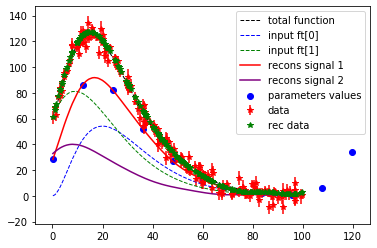

Chi^2 actual= 201.93980717339548 Chi^2 pystan rec= 212.8636746219106


In [321]:
NP=11
tp=np.linspace(np.amin(t), np.amax(t)+dt_max, NP)
pp1=fit5.get_posterior_mean()
pos_mean=np.mean(pp1,axis=1)
P_mean=pos_mean[np.arange(0,NP)]; 
print(pos_mean)
print(len(pos_mean),len(P_mean))
lm=pos_mean[-4]; mum=pos_mean[-3]; dtm=pos_mean[-2];
print("P's are calculated at t= ",tp)


Ps1=get_GP_mean(tp,P_mean,t,lm)
Ps2=mum*get_GP_mean(tp,P_mean,t+dtm,lm)

rconst_signal=Ps1+Ps2#+Ps3+Ps4;
Ps=Ps1+Ps2

plt.errorbar(t,y,yerr=sigft,fmt='r*',label=r"data") #data
plt.plot(t,ft_total,c='k',lw=1.0,ls="--", label=r"total function")
clr=["b","g","c","orange"]
for i in range(NI):
    plt.plot(t,ft[i],c=clr[i],lw=1.0,ls="--", label=r"input ft[%d]"%(i))

plt.plot(t,Ps1,c="r",label="recons signal 1")  
plt.plot(t,Ps2,c="purple",label="recons signal 2") 
plt.errorbar(t,Ps,fmt='g*',label=r"rec data") #data    
plt.scatter(tp,P_mean,c='b',label="parameters values")
plt.legend(loc=0)
plt.show()
chisq=np.sum((Ps-y)**2/sigft**2)
chisq_o=np.sum((ft_total-y)**2/sigft**2)
print("Chi^2 actual=",chisq_o,"Chi^2 pystan rec=",chisq)